# Client churn

Clients began to leave Beta Bank. Every month. A little, but noticeable. Bank marketers have calculated that it is cheaper to retain current customers than to attract new ones.

It is necessary to predict whether the client will leave the bank in the near future or not. You are provided with historical data on customer behavior and termination of contracts with the bank.

Build a model with an extremely large *F1*-measure. To pass the project successfully, you need to bring the metric to 0.59. Check the *F1*-measure on the test sample yourself.

Additionally, measure *AUC-ROC*, compare its value with the *F1* measure.

Data source:[https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Data pre

Import of libraries:

In [16]:
import piplite
await piplite.install('numpy')
await piplite.install('pandas')
await piplite.install('matplotlib')
await piplite.install('seaborn')
await piplite.install('imblearn')
await piplite.install('scikit-learn')

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

#from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import (accuracy_score,
                             mean_squared_error,
                             confusion_matrix ,
                             f1_score,
                             roc_curve,
                             roc_auc_score
                            )

from sklearn.preprocessing import OneHotEncoder, StandardScaler

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler 
                             

Loading data:

In [19]:
try:
    df=pd.read_csv('/datasets/Churn.csv')
except:
    df=pd.read_csv('Churn.csv')
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


Features
- RowNumber — row index in the data
- CustomerId — unique client identifier
- Surname - surname
- CreditScore - credit rating
- Geography - country of residence
- Gender - gender
- Age - age
- Tenure - how many years a person has been a bank client
- Balance - account balance
- NumOfProducts — number of bank products used by the client
- HasCrCard - availability of a credit card
- IsActiveMember — client activity
- EstimatedSalary - estimated salary

Target feature
- Exited—the fact that the client has left

We need to solve the problem of binary classification.

In [20]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 976.6+ KB


Data preparation:

At first glance, data type changes are not required. Let's estimate the number of passes:

In [22]:
pd.DataFrame(round(df.isna().mean()*100,)).style.background_gradient('coolwarm')

,0
RowNumber,0.000000
CustomerId,0.000000
Surname,0.000000
CreditScore,0.000000
Geography,0.000000
Gender,0.000000
Age,0.000000
Tenure,9.000000
Balance,0.000000
NumOfProducts,0.000000


9% of the data in 'Tenure' is missing, let's delete these lines.

Here we prefer deletion, because these omissions are random and cannot be restored through other columns.

In [23]:
df = df.dropna()
df.isna().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

Checking for excplicit duplicates:

In [24]:
df.duplicated().sum()

0

Checking for implicit duplicates - let's check whether there are clients with the same categorical characteristics:

In [25]:
df_duplicated= df[df[['Surname', 'Age','Geography','Tenure','Gender']].duplicated(keep=False)]
df_duplicated

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
437,438,15624623,Hs?,516,France,Male,35,10.0,104088.59,2,0,0,119666.00,0
1046,1047,15644200,Hamilton,807,Spain,Female,42,1.0,0.00,1,1,0,16500.66,1
1442,1443,15796179,Moore,683,France,Male,43,8.0,0.00,1,1,0,96754.80,0
1555,1556,15709994,Gallo,658,France,Female,40,7.0,140596.95,1,0,1,135459.02,1
1776,1777,15674851,T'ien,622,France,Male,38,5.0,0.00,2,0,0,105295.77,0
2064,2065,15569503,Yeh,765,France,Male,44,6.0,0.00,2,1,1,159899.97,0
2320,2321,15775888,McDonald,593,Germany,Female,38,5.0,85626.60,1,1,1,125079.65,0
2355,2356,15710366,Hamilton,569,Spain,Female,42,1.0,0.00,1,1,1,83629.60,1
2501,2502,15753370,McDonald,691,Germany,Female,38,5.0,114753.76,1,1,0,107665.02,0
3081,3082,15603319,Graham,693,France,Male,29,2.0,151352.74,1,0,0,197145.89,0


Even though it is possible that the clients are people with the same last name, country, age, gender and they have been clients of the bank for the same length of time, this looks suspicious. It is possible that data for such clients was entered several times as for a new client. Just in case, let's delete this data. Here it would be useful to also have the client's name/passport details to eliminate such duplicates.

In [26]:
df = df[~(df[['Surname', 'Age','Geography','Tenure','Gender']].duplicated(keep=False))]
df

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9994,9995,15719294,Wood,800,France,Female,29,2.0,0.00,2,0,0,167773.55,0
9995,9996,15606229,Obijiaku,771,France,Male,39,5.0,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35,10.0,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36,7.0,0.00,1,0,1,42085.58,1


You can also remove the "RowNumber" , "CustomerId" and "Surname" columns from the dataset.

In [27]:
df = df.drop(df.columns[[0,1,2]], axis=1)
df

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...
9994,800,France,Female,29,2.0,0.00,2,0,0,167773.55,0
9995,771,France,Male,39,5.0,0.00,2,1,0,96270.64,0
9996,516,France,Male,35,10.0,57369.61,1,1,1,101699.77,0
9997,709,France,Female,36,7.0,0.00,1,0,1,42085.58,1


We will work with this dataset. Let's look at the distribution of values in the columns:

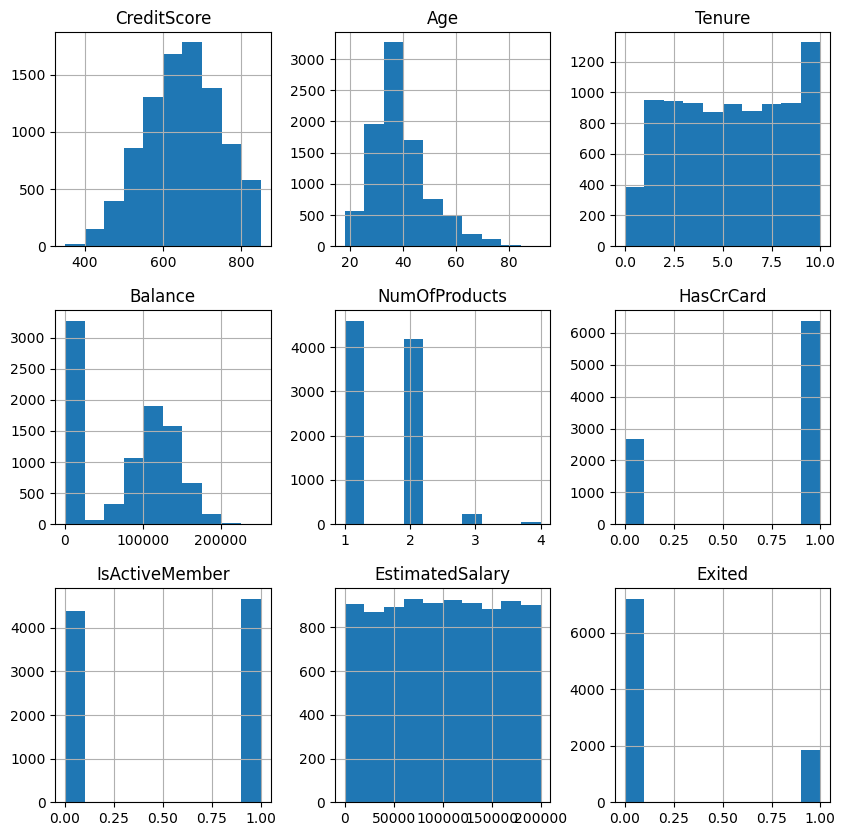

In [28]:
df.hist(figsize=(10,10))

plt.show()

Note that the number of banking products for most clients is 1 or 2, and very small for 3-4. There are approximately the same number of active clients as inactive ones. The age of clients reaches a maximum of 35-40 years. For distribution by account balance there is an "outlier" at zero, which means that these clients do not hold money in this bank.

**Conclusion from step 1**. The data has been downloaded and studied - the dataset is of good quality, preprocessing was carried out only to remove gaps in one column and identify implicit duplicates.

## Problem research

Problem: Investigate class balance, train a model without taking into account imbalance. Briefly describe your findings.

Let's consider the balance of classes for parameters Exited, Geography, Gender.

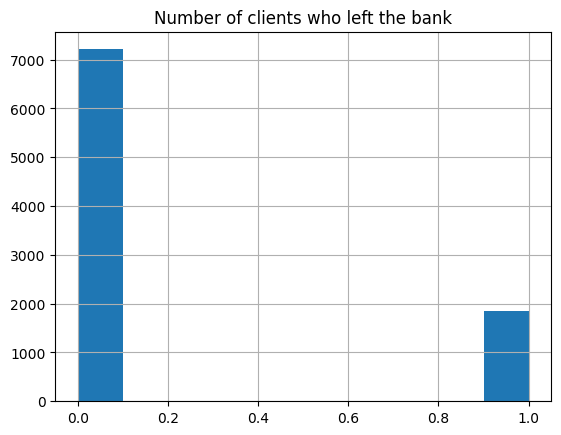

In [29]:
df['Exited'].hist()
plt.title('Number of clients who left the bank')
plt.show()

In [30]:
len(df.query('Exited==1'))/len(df)

0.20399602605144054

The ratio of those who left the bank to those who remained ~4:1

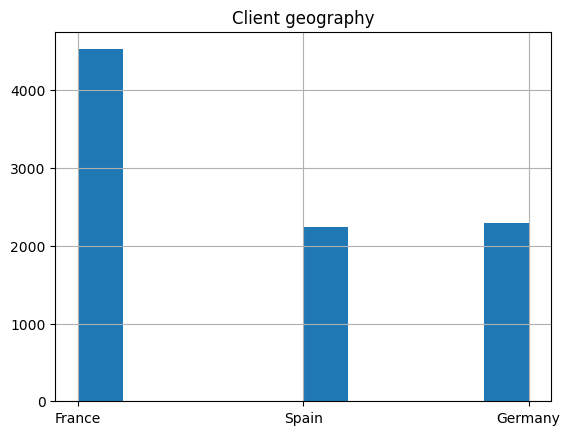

In [31]:
df['Geography'].hist()
plt.title('Client geography')
plt.show()

In [32]:
len(df.query('Geography=="France"'))/len(df), len(df.query('Geography=="Spain"'))/len(df), len(df.query(
    'Geography=="Germany"'))/len(df)

(0.49983441881002316, 0.24770946020532067, 0.25245612098465614)

Ratio by country France : Spain : Germany ~ 2:1:1

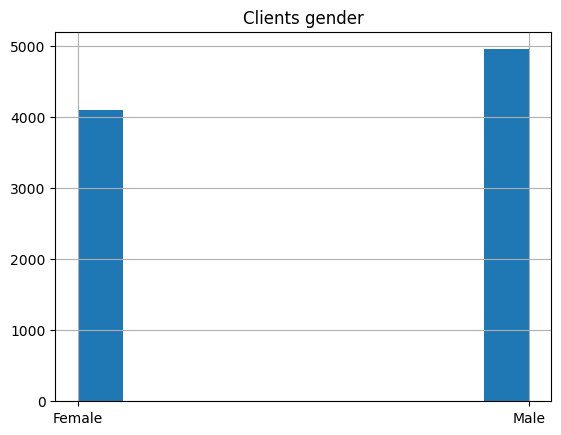

In [33]:
df['Gender'].hist()
plt.title('Clients gender')
plt.show()

In [34]:
len(df.query('Gender=="Female"'))/len(df)

0.45314052323656034

Gender ratio of clients F:M ~ 9:13. 

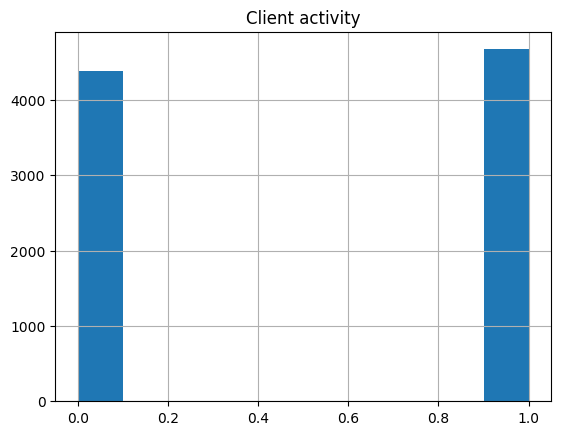

In [35]:
df['IsActiveMember'].hist()
plt.title('Client activity')
plt.show()

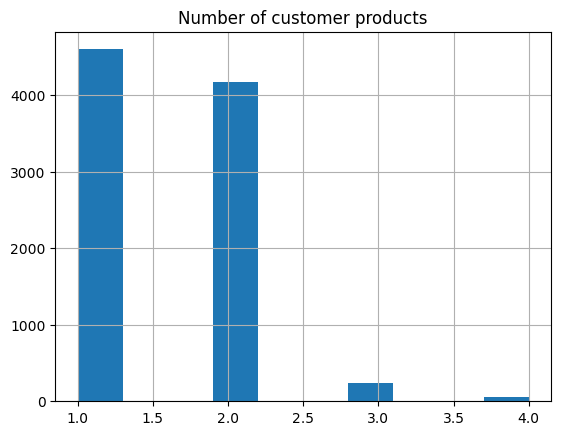

In [36]:
df['NumOfProducts'].hist()
plt.title('Number of customer products')
plt.show()

In [37]:
print(f'Proportion of customers with 1 product:, {round(len(df.query("NumOfProducts==1"))/len(df),2)}')
print(f'Proportion of customers with 2 products:, {round(len(df.query("NumOfProducts==2"))/len(df),2)}')
print(f'Proportion of customers with 3 products:, {round(len(df.query("NumOfProducts==3"))/len(df),2)}')
print(f'Proportion of customers with 4 products:, {round(len(df.query("NumOfProducts==4"))/len(df),2)}')

Proportion of customers with 1 product:, 0.51
Proportion of customers with 2 products:, 0.46
Proportion of customers with 3 products:, 0.03
Proportion of customers with 4 products:, 0.01


In [38]:
#Let's look at the share of abandoned customers for each number of products
round(len(df.query("NumOfProducts==1 and Exited==1"))/len(df.query("NumOfProducts==1")),2), round(
     len(df.query("NumOfProducts==2 and Exited==1"))/len(df.query("NumOfProducts==2")),2), round(
     len(df.query("NumOfProducts==3 and Exited==1"))/len(df.query("NumOfProducts==3")),2), round(
     len(df.query("NumOfProducts==4 and Exited==1"))/len(df.query("NumOfProducts==4")),2)

(0.28, 0.08, 0.82, 1.0)

It turns out that customers with 3 and 4 products left in 82 and 100% of cases, respectively.

There is also a class imbalance here. First, we train the model without taking this imbalance into account.

**Model training - feature coding**

Let's break down the data into samples, and then apply coding and scaling techniques.


Let's select the target feature and split the data 60-20-20%

In [40]:
features = df.drop('Exited', axis=1)
target = df['Exited']  
#training sample 60%
features_train, features_valid,  target_train, target_valid = train_test_split(
    features, target, test_size=0.4, random_state=12345)
#validation sample
features_test, features_valid,  target_test, target_valid = train_test_split(
    features_valid, target_valid, test_size=0.5, random_state=12345)

print(features_train.shape, features_valid.shape, features_test.shape)
print(target_train.shape, target_valid.shape, target_test.shape)


(5435, 10) (1812, 10) (1812, 10)
(5435,) (1812,) (1812,)


Let's encode categorical features. First, let's extract numerical features, excluding binary ones.

In [41]:
num_features = features_train.select_dtypes(exclude='object').columns.to_list()
num_features.remove('HasCrCard')
num_features.remove('IsActiveMember')
num_features

['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']

Training sample encoding:

In [42]:
# drop='first' removes the first attribute from the encoded ones:
# set handle_unknown='ignore':
# previously unoccurring attribute values are ignored (during transform)
ohe_features = ['Gender', 'Geography']
encoder_ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)

# train the encoder using the given categorical features of the training set
encoder_ohe.fit(features_train[ohe_features])

# add encoded features to X_train_ohe
# encoder_ohe.get_feature_names_out() allows you to get column names
features_train[
     encoder_ohe.get_feature_names_out()
] = encoder_ohe.transform(features_train[ohe_features])

# remove unencoded categorical features (initial columns)
features_train = features_train.drop(ohe_features, axis=1)

/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [43]:
features.shape, features_train.shape

((9059, 10), (5435, 11))

Let's carry out scaling of numerical features.

In [44]:
# creating a scaler
scaler = StandardScaler()

# train it on the numerical characteristics of the training sample, transform it
features_train[num_features] = scaler.fit_transform(features_train[num_features])

# result
features_train.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Gender_Male,Geography_Germany,Geography_Spain
5859,0.736981,-0.088648,0.692100,-1.235555,-0.910652,0,1,-0.813980,1.0,0.0,1.0
9659,1.776239,0.290424,-0.691718,0.172630,0.794860,1,1,-0.621681,1.0,1.0,0.0
4150,1.152684,-0.562488,0.346146,0.978445,0.794860,1,0,0.839188,0.0,0.0,0.0
9514,2.025661,-1.036328,1.384010,-1.235555,0.794860,1,1,-0.767963,0.0,0.0,0.0
6448,0.310885,-0.183416,0.346146,0.755315,0.794860,1,0,-0.131994,0.0,0.0,1.0


Encoding and scaling the training set:

In [45]:
features_valid[
    encoder_ohe.get_feature_names_out()
] = encoder_ohe.transform(features_valid[ohe_features])

features_valid = features_valid.drop(ohe_features, axis=1)

# using the scaler to fit validation data
features_valid[num_features] = scaler.transform(
    features_valid[num_features]
)

# смотрим на результат
features_valid.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Gender_Male,Geography_Germany,Geography_Spain
9146,0.227744,0.100888,-0.345764,0.192173,0.794860,1,0,1.535429,1.0,1.0,0.0
7424,-0.832300,-0.088648,-1.383628,0.804405,-0.910652,1,0,0.811224,1.0,1.0,0.0
1704,0.040677,-0.941560,-0.345764,0.319654,-0.910652,0,1,0.711174,0.0,0.0,0.0
3153,0.539522,-0.941560,0.346146,1.157494,-0.910652,1,1,-1.575987,0.0,0.0,0.0
6465,0.830514,-1.225864,0.346146,-1.235555,0.794860,1,1,1.481908,1.0,0.0,1.0


Кодирование и масштабирование тестовой выборки:

In [46]:
features_test[
    encoder_ohe.get_feature_names_out()
] = encoder_ohe.transform(features_test[ohe_features])

features_test = features_test.drop(ohe_features, axis=1)

# скелером, который обучен на ТРЕНИРОВОЧНОЙ ВЫБОРКЕ, масштабируем тестовую
features_test[num_features] = scaler.transform(
    features_test[num_features]
)

# result
features_test.head()


,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Gender_Male,Geography_Germany,Geography_Spain
9917,-0.156782,1.332872,1.038055,0.640889,-0.910652,0,1,0.402955,1.0,1.0,0.0
6878,0.009500,-0.372952,-1.729583,1.680365,0.794860,0,1,-1.102301,1.0,0.0,0.0
7278,-0.084034,-0.562488,-0.345764,0.121312,0.794860,0,1,-0.700731,0.0,0.0,0.0
744,-0.000893,1.996248,1.038055,-1.235555,0.794860,1,1,0.043303,1.0,0.0,0.0
3387,-1.175255,4.270680,1.038055,0.243756,-0.910652,1,1,1.489325,1.0,1.0,0.0


Let's train the model without working on the imbalance and using the class_weight argument.

**Model 1. Logistic regression - without taking into account imbalance.**

Let's consider the model and its metric F1

In [47]:
model = LogisticRegression(solver='liblinear', random_state=12345)
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
result= model.score(features_valid, target_valid)
  
print("F1:", f1_score(target_valid, predicted_valid))

F1: 0.2901960784313726


F1 low, 0.29. Let's display the ROC-AUC value

In [48]:
def print_auc_roc(target,features):
    probabilities_valid = model.predict_proba(features)
    probabilities_one_valid = probabilities_valid[:, 1]
    
    auc_roc = roc_auc_score(target, probabilities_one_valid)
    print("ROC-AUC:" ,auc_roc)

In [49]:
print_auc_roc(target_valid,features_valid)

ROC-AUC: 0.75149649683695


**Model 2. Decision tree.** Let's find a decision tree with a depth corresponding to the highest accuracy of the model.

In [50]:
best_result=0
best_model= None

for depth in range(1, 16):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model.fit(features_train, target_train)
    predicted_valid = model.predict(features_valid)
    result = f1_score(target_valid, predicted_valid)
    print(result, depth)    
    if result > best_result:
        best_model = model
        best_result = result
        best_depth = depth
print()        
#print('accuracy=', best_result, 'Высота дерева лучшей модели depth=', best_depth)
print("F1:", best_result, 'Tree height of the best model depth=', best_depth)
print_auc_roc(target_valid,features_valid)

0.0 1
0.5177195685670262 2
0.3839662447257384 3
0.5120274914089347 4
0.577639751552795 5
0.5593220338983051 6
0.6029850746268656 7
0.5674846625766872 8
0.5718608169440241 9
0.5601217656012176 10
0.5195936139332366 11
0.5209840810419682 12
0.5106382978723405 13
0.5020804438280166 14
0.5 15

F1: 0.6029850746268656 Tree height of the best model depth= 7
ROC-AUC: 0.6928119024404993


When the tree height is 7, the maximum value of F1 value is 0.603. ROC-AUC value 0.693.

**Model 3. Random forest.** Let's select the number of trees.

In [51]:
best_model = None
best_result = 0
for est in range (190,200):
    for depth in range(12,16):
        model = RandomForestClassifier(random_state=12345, n_estimators= est, max_depth=depth) 
        model.fit(features_train, target_train)
        predicted_valid = model.predict(features_valid)
        result = f1_score(target_valid, predicted_valid)
        #print(result, est, depth)
        if result > best_result:
            best_model = model 
            best_result = result 
            best_depth = depth
            best_est = est
print()
print("F1 of the best model on the validation set:", best_result, "Height of trees:", best_depth, "Number of trees", best_est )

print_auc_roc(target_valid,features_valid)


F1 of the best model on the validation set: 0.5699658703071673 Height of trees: 12 Number of trees 192
ROC-AUC: 0.8502520614621831


The best value f1= 0.570 was achieved with 192 trees and tree height 12.

**Conclusion from step 2**. There is a class imbalance in the data. When building models, the highest f1-measure value of 0.603 was shown by the decision tree model with a tree height equal to 7.ROC-AUC and 0.69 being less than that of a random forest (0.853).

It is necessary to analyze the model, first eliminating the imbalance.

## Fighting Imbalance

To eliminate the imbalance we will use upsamplimg/downsampling.

In [52]:
"""oversample = SMOTE(random_state=12345,k_neighbors=4)

features_train_up, target_train_up = oversample.fit_resample(features_train, target_train)"""

'oversample = SMOTE(random_state=12345,k_neighbors=4)\n\nfeatures_train_up, target_train_up = oversample.fit_resample(features_train, target_train)'

In [53]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

features_train_up, target_train_up = upsample(features_train, target_train, 4)

Now let's train the models with “new” samples.

**Logistic Regression - upsamplimg**

In [37]:
model = LogisticRegression(random_state=12345, solver='liblinear')
model.fit(features_train_up, target_train_up)
predicted_valid= model.predict(features_valid)
print("F1:", f1_score(target_valid, predicted_valid))
print_auc_roc(target_valid,features_valid)

F1: 0.4919583727530748
ROC-AUC: 0.7528437218934465


The F1 metric increased noticeably in the case of training on a balanced sample.

**Decision Tree - upsampling.** 

In [55]:
best_result=0
best_model= None

for depth in range(1, 20):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model.fit(features_train_up, target_train_up) 
    predicted_valid = model.predict(features_valid)
    result = f1_score(target_valid, predicted_valid)
    print(result, depth)    
    if result > best_result:
        best_model = model
        best_result = result
        best_depth = depth
print()        

print("F1:", best_result, 'Depth of the best  model depth=', best_depth)
print_auc_roc(target_valid,features_valid)

0.4715615305067219 1
0.5115346038114342 2
0.532620320855615 3
0.5216589861751152 4
0.5878220140515223 5
0.5656970912738215 6
0.5571725571725572 7
0.550098231827112 8
0.5472527472527472 9
0.5321888412017168 10
0.5292792792792793 11
0.5333333333333333 12
0.5188794153471377 13
0.5139949109414758 14
0.5209656925031766 15
0.5117493472584858 16
0.5112582781456954 17
0.5181208053691275 18
0.5136612021857924 19

F1: 0.5878220140515223 Depth of the best  model depth= 5
ROC-AUC: 0.6972522655299337


The F1 value increased to 0.588, but still lower than in the model without taking into account imbalance.

**Random Forest - upsampling.**

In [56]:
best_model = None
best_result = 0

for est in range(120,125):
    for depth in range(10,15):
        model = RandomForestClassifier(random_state=12345, n_estimators= est, max_depth=depth) 
        model.fit(features_train_up, target_train_up)
        predicted_valid = model.predict(features_valid)
        result = f1_score(target_valid, predicted_valid)
        print(result, est, depth)
        if result > best_result:
            best_model = model 
            best_result = result 
            best_est = est
            best_depth= depth
print()

print("F1-measure of the best model on an enlarged validation set:", best_result, "Trees:", best_est, "Depth", depth)


0.6206896551724138 120 10
0.6163366336633663 120 11
0.619718309859155 120 12
0.6222222222222222 120 13
0.6181318681318682 120 14
0.6181384248210023 121 10
0.6165228113440198 121 11
0.6214833759590792 121 12
0.6256544502617801 121 13
0.6183310533515733 121 14
0.6197854588796187 122 10
0.617283950617284 122 11
0.6214833759590792 122 12
0.6264744429882044 122 13
0.6134800550206327 122 14
0.6214285714285716 123 10
0.617283950617284 123 11
0.619718309859155 123 12
0.6264744429882044 123 13
0.6145404663923182 123 14
0.6205250596658711 124 10
0.6157635467980296 124 11
0.618925831202046 124 12
0.6264744429882044 124 13
0.6151724137931034 124 14

F1-measure of the best model on an enlarged validation set: 0.6264744429882044 Trees: 122 Depth 14


With the value max_depth=14 and the number of trees est=122, F1 0.626 was achieved.

Для уменьшения выборки используем RandomUnderSampler

In [41]:
rus = RandomUnderSampler()
features_train_down, target_train_down = rus.fit_resample(features_train, target_train)


**Логистическая регрессия - downsampling**

In [42]:
model = LogisticRegression(solver='liblinear', random_state=12345)
model.fit(features_train_down, target_train_down)
predicted_valid = model.predict(features_valid)


print("F1:", f1_score(target_valid, predicted_valid))
print_auc_roc(target_valid,features_valid)

F1: 0.4995251661918329
ROC-AUC: 0.7517931508816483


Мера F1 немного ниже, чем при увеличенной выборке, но все же гораздо выше, чем для дисбалансированной выборки.

**Дерево решений - downsampling.**

In [43]:
best_result=0
best_model= None

for depth in range(1, 20):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model.fit(features_train_down, target_train_down)
    predicted_valid = model.predict(features_valid)
    result = f1_score(target_valid, predicted_valid)
    print(result, depth)    
    if result > best_result:
        best_model = model
        best_result = result
        best_depth = depth
print()        

print("F1:", best_result, 'Высота дерева лучшей модели depth=', best_depth)
print_auc_roc(target_valid,features_valid)

0.4715615305067219 1
0.5115346038114342 2
0.5115346038114342 3
0.5406464250734574 4
0.5585774058577405 5
0.5365384615384616 6
0.5478887744593203 7
0.5356773526370217 8
0.5015166835187057 9
0.48679245283018874 10
0.4618284637134778 11
0.47070124879923153 12
0.47393364928909953 13
0.460093896713615 14
0.45783132530120485 15
0.44566210045662097 16
0.4598130841121495 17
0.455743879472693 18
0.46139534883720934 19

F1: 0.5585774058577405 Высота дерева лучшей модели depth= 5
ROC-AUC: 0.6793925583293653


F1 здесь ниже, чем для увеличенной выборки.

**Случайный лес - downsampling.** Подбираем количество деревьев и глубину.

In [44]:
best_model = None
best_result = 0

for est in range(100,130,2):
    for depth in range(5,15):
        model = RandomForestClassifier(random_state=12345, n_estimators= est, max_depth=depth) 
        model.fit(features_train_down, target_train_down)
        predicted_valid = model.predict(features_valid)
        result = f1_score(target_valid, predicted_valid)
        #print(result, est, depth)
        if result > best_result:
            best_model = model 
            best_result = result 
            best_est = est
            best_depth= depth
print()

print("F1-мера наилучшей модели на уменьшенной валидационной выборке:", best_result, "Деревьев:", best_est, "Глубина", depth)
print_auc_roc(target_valid,features_valid)


F1-мера наилучшей модели на уменьшенной валидационной выборке: 0.6075675675675676 Деревьев: 124 Глубина 14
ROC-AUC: 0.849375325941546


Здесь также уменьшается мера F1.


**Вывод по шагу 3:**

При изменении размера выборки наибольшее значение F1 показала модель Случайный лес на увеличенной выборке, с max_depth=14 и n_est=125, F1 = 0.628, ROC-AUC: 0.85.



## Model Testng

Let's test the model with the hyperparameters selected earlier:

In [57]:
model = RandomForestClassifier(random_state=12345, n_estimators= 122, max_depth=14)
model.fit(features_train_up, target_train_up)
predicted_test= model.predict(features_test)
result = f1_score(target_test, predicted_test)
print("F1 on test sample:", result) #
print_auc_roc(target_test,features_test)

F1 on test sample: 0.5908460471567268
ROC-AUC: 0.8375423391113768


F1 of the best model on the test set: 0.591

Let's build an ROC curve for the test sample.

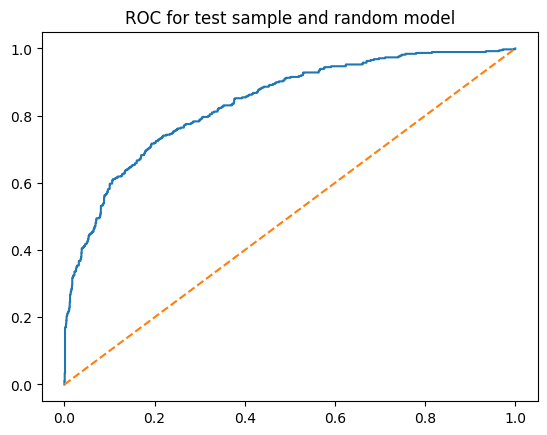

In [58]:
probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)
auc_roc = roc_auc_score(target_test, probabilities_one_test)

plt.plot(fpr, tpr, label='RandomForestClassifier')

plt.plot([0, 1], [0, 1], linestyle='--', label='RandomModel')
plt.title('ROC for test sample and random model')
plt.show()


The higher the ROC curve, the better. In this case, a fairly high value of ROC_AUC = 0.843 was achieved for the test model.

# Conclusion:
- The data has been studied and processed. A breakdown was made into training, validation and test samples.
- Class imbalance was studied and models were trained without taking into account the imbalance.
- Classes are balanced by increasing and decreasing samples, models are trained on balanced samples.
- The model has been tested.

     The best result F1-0.591 measure was achieved when training the Random Forest model on an enlarged sample with hyperparameters number of trees -122, depth -14. The AUC-ROC metric was 0.84, which indicates a high probability of being included in the classes.
